In [2]:
from transmitter import *
from reciever import *
import numpy as np
import simpleaudio as sa
from scipy.io.wavfile import read
from scipy.fft import fft
import matplotlib.pyplot as plt

In [3]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21             # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}

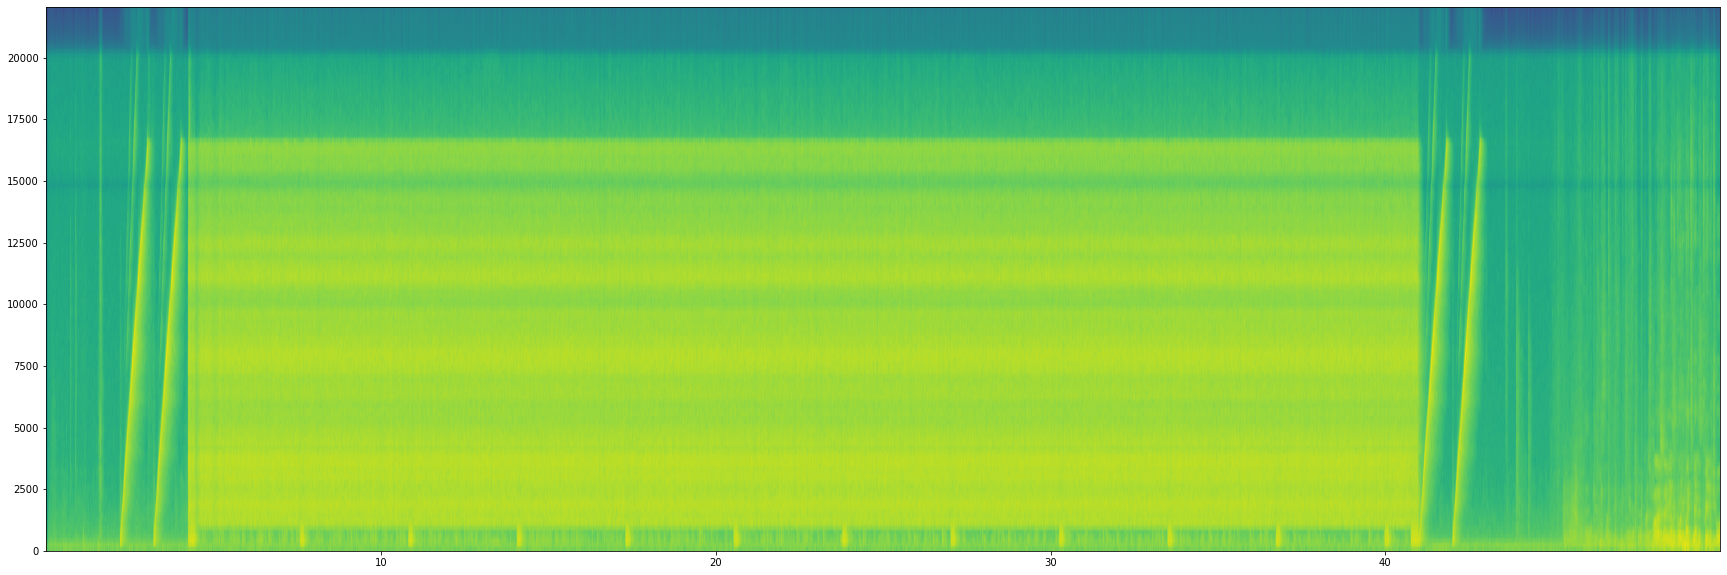

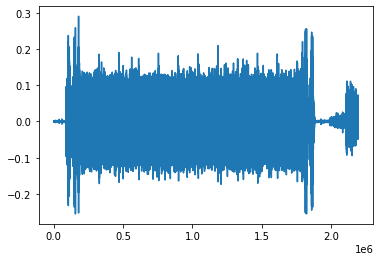

1871021 1796021 1896021 2195000 84865 184865


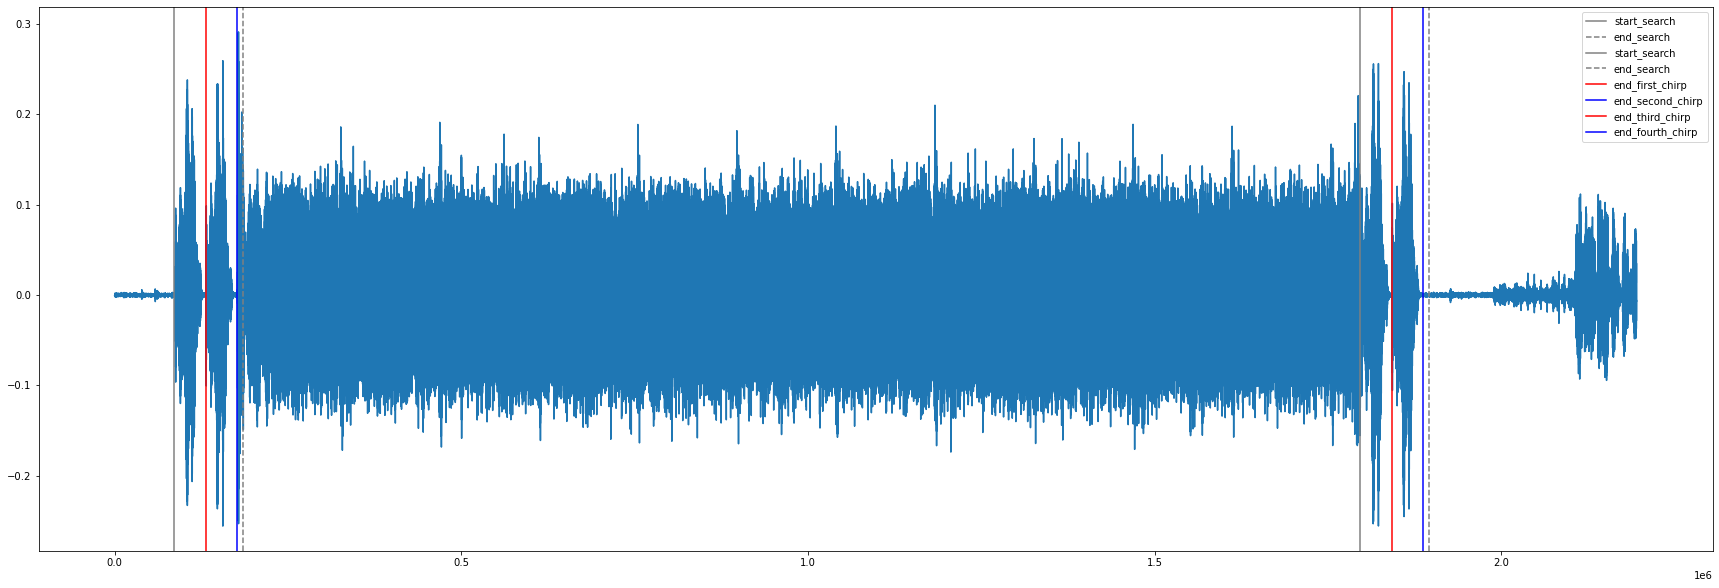

In [4]:
Fs, auds = read('Group_7a_real_rec.wav')
plt.figure(figsize = (30, 10))

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(auds, Fs=fs)
plt.show()
auds = auds[10000:]
plt.plot(auds)
plt.show()
try:
    chirps = chirpEnds(auds, graph_display=True)
except:
    chirps = chirpEnds(-auds, graph_display=True)
delayed_start = chirps[1] + 1500 + 1
delayed_end = chirps[2] - 44100 - 1500 - 1

Difference in end, new, snc?: 9271 1797001 1787730


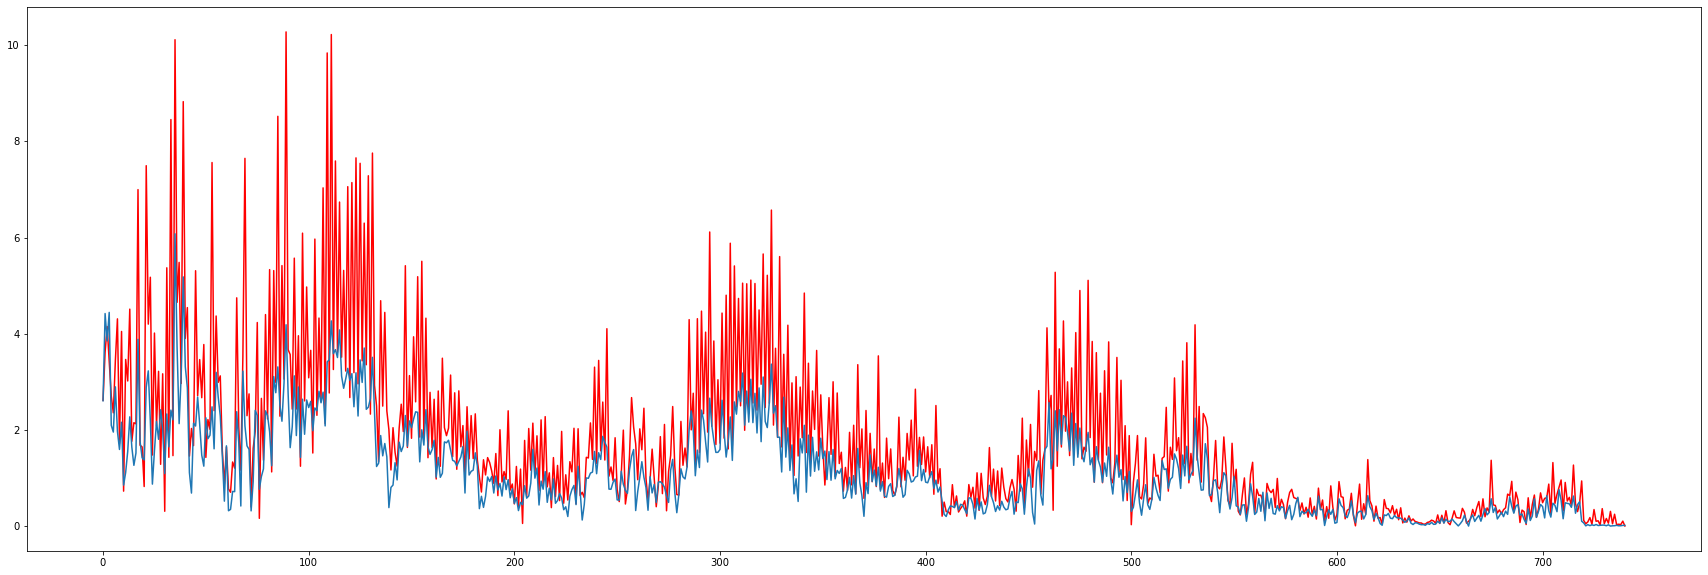

In [6]:
ayy,bee = channelEstimate(auds[delayed_start:delayed_start+2304*4], ofdm)

data_start  = delayed_start+2304*4
delayed_end_snc = delayed_end - 2304*4
num_symbs_guess = round((delayed_end-data_start)/2304)
new_end = data_start + num_symbs_guess*2304
print("Difference in end, new, snc?:", new_end-delayed_end_snc, new_end, delayed_end_snc)
plt.figure(figsize = (30, 10))

plt.plot(abs(ayy),color='r')
plt.plot(abs(bee))

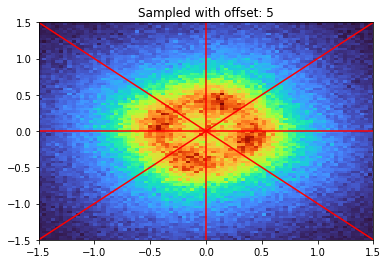

In [37]:
of=5
fo=0
roteat =  0*-0.3j

win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('hamming', win_len)
resampled_aud = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start) #chanest_padd(ayy,ofdm)

decoded, symbols_rec = standard_deconstructor(resampled_aud,ofdm,channel_H=chanest_padd(ayy,ofdm),retSymbs=True,ldpc_encoded=False,add_rotate=roteat)

plt.hist2d(np.real(symbols_rec.flatten()), np.imag(symbols_rec.flatten()), bins=(4000, 4000), cmap=plt.cm.turbo)
plt.axvline(x = 0 , color = 'r')
plt.axhline(y = 0 , color = 'r')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axline((-2,-2), (2,2), color ='r')
plt.axline((2,-2), (-2,2), color ='r')
plt.title('Sampled with offset: {}'.format(of))
plt.show()


In [6]:

win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('hamming', win_len)
resampled_aud2 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start)
resampled_aud_win = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start, window = win)

#decoded, symbols_rec = standard_deconstructor(resampled_aud4, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True)
decoded2, symbols_rec2 = standard_deconstructor(resampled_aud2, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, add_rotate=roteat, ldpc_encoded = True)
decoded_win, symbols_rec_win = standard_deconstructor(resampled_aud_win, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, add_rotate=roteat, ldpc_encoded = True)

fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 300)

axs[0].hist2d(np.real(symbols_rec_win.flatten()), np.imag(symbols_rec_win.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
axs[0].axvline(x = 0 , color = 'r')
axs[0].axhline(y = 0 , color = 'r')
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)
axs[0].set_xlabel("Re")
axs[0].set_ylabel("Im")
axs[0].set_title("After Resampling - Window")


axs[1].hist2d(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
axs[1].axvline(x = 0 , color = 'r')
axs[1].axhline(y = 0 , color = 'r')
axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
axs[1].set_xlabel("Re")
axs[1].set_ylabel("Im")
axs[1].set_title("After Resampling - No Window")

(727200,)
727056
(727056,)


KeyboardInterrupt: 

In [25]:
header = decoded[:7*8*3]
header[:7*8], header[7*8:7*8*2], header[7*8*2:7*8*3]

print(''.join([str(i) for i in header[:7*8]]))
print(''.join([str(i) for i in header[7*8:7*8*2]]))
print(''.join([str(i) for i in header[7*8*2:7*8*3]]))


file_type, data_len = decode_header(decoded)
print(file_type,data_len)
data = decoded[7*8*3:data_len*8]
str_data = [str(i) for i in data]
bytes_int = [int(''.join(map(str, str_data[i:i+8])),2) for i in range(0, len(str_data), 8)]
with open("trialb_group_1{}".format(file_type), 'wb') as f:
    f.write(bytearray(bytes_int))

01100010001111101111010000010000001010010110000101011100
10010111011111110110001100000000100000111110111000100010
11110100111111101111110100101110100000100110110000000011


ValueError: There are too many errors in the input header

In [26]:
data = decoded[7*8:257072+7*8]
str_data = [str(i) for i in data]
bytes_int = [int(''.join(map(str, str_data[i:i+8])),2) for i in range(0, len(str_data), 8)]


with open("trial_rand{}".format('.txt'), 'wb') as f:
    f.write(bytearray(bytes_int))


In [ ]:
# turn back into a byte array

bit_array = [(''.join(map(str, data[i:i+8])),2)[0] for i in range(0, len(str_data), 8)]
print(bit_array)
abc = [int(x,base=2) for x in bit_array]
abc_bytea = bytearray(abc)

# Turn array into form PIL likes
abc = np.array(abc).reshape((104, 433, -1 ))
abc = Image.fromarray(abc.astype(np.uint8))

# Save image
img = Image.fromarray(np.array(abc))
img.save("trial_group_8e.tiff")



['01110100', '01101001', '01100110', '01100110', '00000000', '10101111', '11101000', '01110100', '01101001', '01100110', '01100110', '00000000', '10101111', '11101000', '01001001', '01001001', '00101010', '00000000', '00001000', '00000000', '00000000', '00000000', '00001101', '00000000', '00000000', '00000001', '00000011', '00000000', '00000001', '00000000', '00000000', '00000000', '01011110', '00000001', '00000000', '00000000', '00000001', '00000001', '00000011', '00000000', '00000001', '00000000', '00000000', '00000000', '11100001', '00000000', '00000000', '00000000', '00000010', '00000001', '00000011', '00000000', '00000011', '00000000', '00000000', '00000000', '11010000', '10101111', '00000000', '00000000', '00000011', '00000001', '00000011', '00000000', '00000001', '00000000', '00000000', '00000000', '00000111', '00000000', '00000000', '00000000', '00000110', '00000001', '00000011', '00000000', '00000001', '00000000', '00000000', '00000000', '00000010', '00000000', '00000000', '00

TypeError: Cannot handle this data type: (1, 1, 1), |u1

In [ ]:
45032/173

260.3005780346821

39384 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x01,\x01,\x00\x00\xff\xe1\x00\x8cExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x05\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00J\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00R\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00Z\x00\x00\x00\x00\x00\x00\x01,\x00\x00\x00\x01\x00\x00\x01,\x00\x00\x00\x01\x00\x03\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x03\x8d\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x01\xff\x00\x00\x00\x00\xff\xed\x008Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xd4\x1d\x8c\xd9\x8f\x00\xb2\x04\xe9\x80\t\x98\xec\xf8B~\xff\xc0\x00\x11\x08\x01\xff\x03\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04

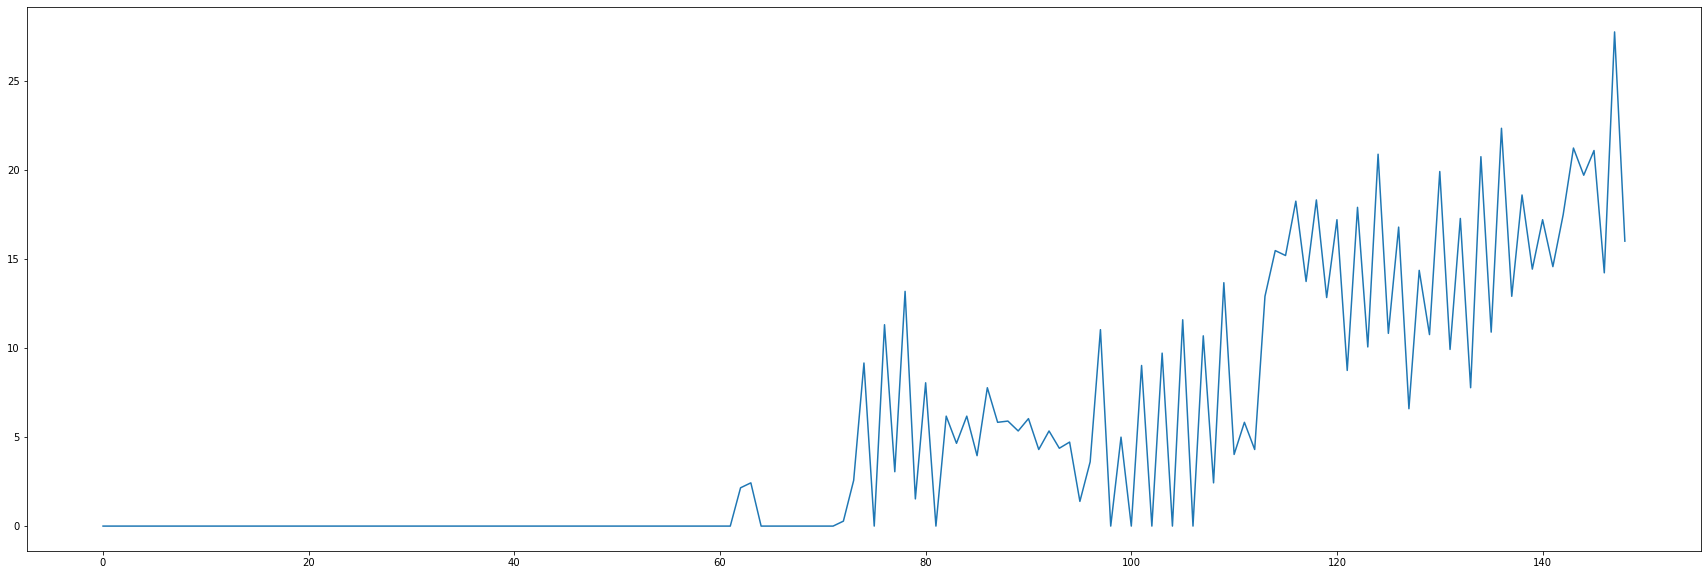

In [ ]:
f = open("pitbull.jpg", "rb")
bytes = f.read()
print(len(bytes),bytes)
plt.figure(figsize = (30, 10))

byte_array = [i for i in bytes]
print(byte_array)
bin_byte_array = ["{0:08b}".format(i) for i in byte_array] # Binary bytes
print(bin_byte_array)
bitty = np.array([bity for bytey in bin_byte_array for bity in bytey]).astype(int)
ldpc = LDPC(rate = ofdm.rate, z = ofdm.z)
ldpc_ified = ldpc.encode(bitty)

bit_array = bitsFromTiff('jaguar.tiff')


print(ldpc_ified)
#plt.plot(errorss(decoded[:39384*8*2], ldpc_ified.flatten()[:39384*8*2]))
plt.plot(errorss(decoded[:26800*8], bit_array))

(521, 2304)
[ 60  61 122 123 184 185 246 247 308 309 370 371 432 433 494 495]
(16, 2304) 501
0
2
4
6
8
10
12
14


((741,), (2048,), (9, 2048))

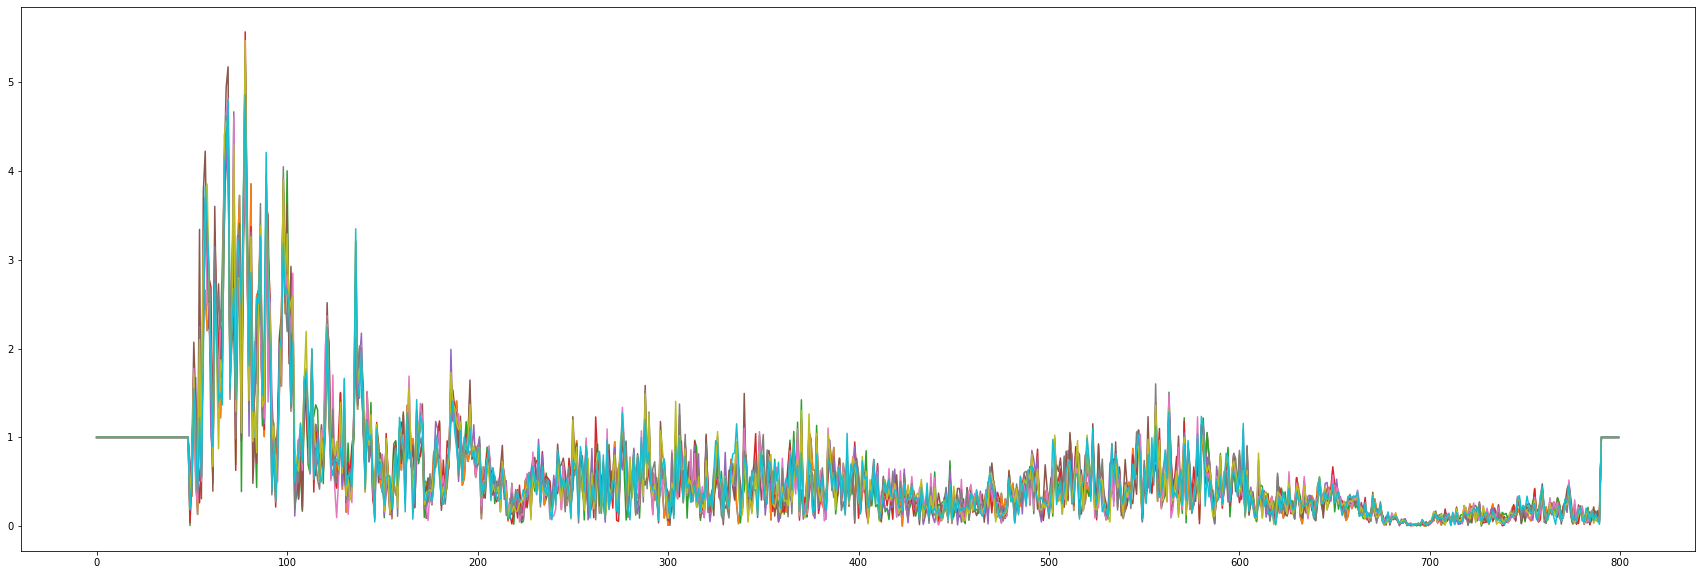

In [8]:

symbols = resampled_aud.reshape((-1,ofdm.N+ofdm.CP))
print(np.shape(symbols))
l = symbols.shape[0]- 4
a1 = np.arange(60, l, 62)
a2 = np.arange(61, l, 62)
at = np.concatenate((a1,a2))
sc_indices = [i for i in range(l) if i not in at]
tot_sym_numb = len(resampled_aud)/(ofdm.N+ofdm.CP)
at = np.sort(at)
print(at)

sc_symbs = symbols[at]
print(np.shape(sc_symbs), len(sc_indices))
chan_est = []
chan_est.append(chanest_padd(ayy,ofdm))
for i in range(0,len(sc_symbs),2):
    print(i)
    chan_est.append(chanest_padd(twoSymbCE(np.concatenate((sc_symbs[i],sc_symbs[i+1])), ofdm),ofdm))

plt.figure(figsize = (30, 10))

plt.plot(abs(chanest_padd(ayy,ofdm))[:800])

for i in chan_est:
    plt.plot(abs(i)[:800])

np.shape(ayy), np.shape(chanest_padd(ayy,ofdm)), np.shape(chan_est)

0 0


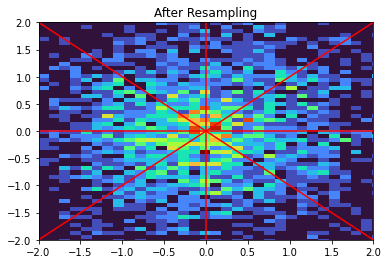

In [9]:
decoded5, symbols_rec5 = standard_deconstructor(resampled_aud[-2304*4:],ofdm,channel_H=chan_est,multi_est=True,retSymbs=True,ldpc_encoded=False,add_rotate=roteat)

plt.hist2d(np.real(symbols_rec5[:60].flatten()), np.imag(symbols_rec5[:60].flatten()), bins=(2000, 2000), cmap=plt.cm.turbo)
plt.axvline(x = 0 , color = 'r')
plt.axhline(y = 0 , color = 'r')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.axline((-2,-2), (2,2), color ='r')
plt.axline((2,-2), (-2,2), color ='r')
plt.title('After Resampling')
plt.show()

In [ ]:
plt.plot(errorss(decoded5[:26800*8], bit_array))

IndexError: index 504 is out of bounds for axis 0 with size 504